# MLB Franchise Relocation Analysis

## Research Question
**Do MLB franchise relocations have a statistically significant impact on team performance (win percentage)?**

This notebook analyzes the win/loss performance of MLB franchises before and after relocations to determine if moving to a new city has a measurable effect on team success.

## Dataset Overview
- **Source**: Lahman Baseball Database (Teams.csv)
- **Analysis Period**: 1876-2024 (148 seasons)
- **Total Seasons**: 2,836 analysis-ready seasons
- **Franchises**: 30 modern franchises (10 relocated, 20 stable/expansion)
- **Key Metric**: Win percentage (W / (W + L))

## Relocated Franchises Studied
1. **Atlanta Braves**: Boston (1876-1952) → Milwaukee (1953-1965) → Atlanta (1966-present)
2. **Los Angeles Dodgers**: Brooklyn (1884-1957) → Los Angeles (1958-present)
3. **San Francisco Giants**: New York (1883-1957) → San Francisco (1958-present)
4. **Oakland Athletics**: Philadelphia (1901-1954) → Kansas City (1955-1967) → Oakland (1968-present)
5. **Minnesota Twins**: Washington Senators (1901-1960) → Minnesota (1961-present)
6. **Texas Rangers**: Washington Senators (1961-1971) → Texas (1972-present)
7. **Baltimore Orioles**: St. Louis Browns (1902-1953) → Baltimore (1954-present)
8. **Milwaukee Brewers**: Seattle Pilots (1969) → Milwaukee (1970-present)
9. **Washington Nationals**: Montreal Expos (1969-2004) → Washington (2005-present)
10. **New York Yankees**: Baltimore Orioles (1901-1902) → New York (1903-present)

## 1. Setup and Data Loading

In [14]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_rel, ttest_ind, normaltest, levene, binomtest
import warnings
from typing import Dict, List, Tuple
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


In [15]:
# Load the analysis-ready dataset
df = pd.read_csv('team_seasons_analysis_ready.csv')
relocation_summary = pd.read_csv('relocation_summary.csv')

print(f"Dataset loaded: {len(df):,} team seasons")
print(f"Year range: {df['yearID'].min()} - {df['yearID'].max()}")
print(f"Unique franchises: {df['canonical_franchise'].nunique()}")
print(f"Relocated franchises: {df[df['is_relocated_franchise']]['canonical_franchise'].nunique()}")

# Display first few rows
df.head()

Dataset loaded: 2,836 team seasons
Year range: 1876 - 2024
Unique franchises: 30
Relocated franchises: 10


,yearID,teamID,franchID,lgID,name,W,L,G,W_pct,canonical_franchise,is_relocated_franchise,relocation_year,pre_relocation,post_relocation,years_since_relocation,relocation_era
0,1961,LAA,ANA,AL,Los Angeles Angels,70,91,161,0.435,ANA,False,NaN,False,False,NaN,none
1,1962,LAA,ANA,AL,Los Angeles Angels,86,76,162,0.531,ANA,False,NaN,False,False,NaN,none
2,1963,LAA,ANA,AL,Los Angeles Angels,70,91,161,0.435,ANA,False,NaN,False,False,NaN,none
3,1964,LAA,ANA,AL,Los Angeles Angels,82,80,162,0.506,ANA,False,NaN,False,False,NaN,none
4,1965,CAL,ANA,AL,California Angels,75,87,162,0.463,ANA,False,NaN,False,False,NaN,none


## 2. Exploratory Data Analysis

In [16]:
# Basic statistics for relocated vs non-relocated franchises
relocated_data = df[df['is_relocated_franchise'] == True]
stable_data = df[df['is_relocated_franchise'] == False]

print("=== DATASET COMPOSITION ===")
print(f"Relocated franchise seasons: {len(relocated_data):,} ({len(relocated_data)/len(df)*100:.1f}%)")
print(f"Stable franchise seasons: {len(stable_data):,} ({len(stable_data)/len(df)*100:.1f}%)")

print("\n=== WIN PERCENTAGE DISTRIBUTIONS ===")
print("Relocated Franchises:")
print(relocated_data['W_pct'].describe())
print("\nStable Franchises:")
print(stable_data['W_pct'].describe())

# Test for difference in overall performance
relocated_wpct = relocated_data['W_pct']
stable_wpct = stable_data['W_pct']

t_stat, p_value = ttest_ind(relocated_wpct, stable_wpct)
print(f"\n=== OVERALL COMPARISON ===")
print(f"Relocated franchises mean W%: {relocated_wpct.mean():.3f}")
print(f"Stable franchises mean W%: {stable_wpct.mean():.3f}")
print(f"Difference: {relocated_wpct.mean() - stable_wpct.mean():.3f}")
print(f"T-test p-value: {p_value:.4f}")
print(f"Statistically significant: {'Yes' if p_value < 0.05 else 'No'}")

=== DATASET COMPOSITION ===
Relocated franchise seasons: 1,104 (38.9%)
Stable franchise seasons: 1,732 (61.1%)

=== WIN PERCENTAGE DISTRIBUTIONS ===
Relocated Franchises:
count    1104.000000
mean        0.507743
std         0.089730
min         0.235000
25%         0.444000
50%         0.512000
75%         0.574000
max         0.759000
Name: W_pct, dtype: float64

Stable Franchises:
count    1732.000000
mean        0.498691
std         0.080985
min         0.169000
25%         0.444000
50%         0.500000
75%         0.556000
max         0.798000
Name: W_pct, dtype: float64

=== OVERALL COMPARISON ===
Relocated franchises mean W%: 0.508
Stable franchises mean W%: 0.499
Difference: 0.009
T-test p-value: 0.0054
Statistically significant: Yes


In [17]:
# Relocation summary analysis
print("=== RELOCATION SUMMARY ===")
print(relocation_summary[['franchise', 'current_name', 'relocation_year', 'from_city', 'to_city']].to_string(index=False))

print("\n=== STATISTICAL READINESS ===")
sufficient_data = relocation_summary[relocation_summary['sufficient_data'] == True]
print(f"Franchises with sufficient data (≥10 seasons pre/post): {len(sufficient_data)}/{len(relocation_summary)}")
print("\nFranchises ready for analysis:")
for _, row in sufficient_data.iterrows():
    print(f"  {row['franchise']}: {row['pre_relocation_seasons']} pre + {row['post_relocation_seasons']} post seasons")

print("\n=== WIN PERCENTAGE CHANGES ===")
wpct_summary = relocation_summary[['franchise', 'pre_relocation_avg_wpct', 'post_relocation_avg_wpct', 'wpct_change', 'sufficient_data']].copy()
wpct_summary = wpct_summary.round(3)
wpct_summary = wpct_summary.sort_values('wpct_change', ascending=False)
print(wpct_summary.to_string(index=False))

=== RELOCATION SUMMARY ===
franchise         current_name  relocation_year   from_city              to_city
      ATL       Atlanta Braves             1966   Milwaukee              Atlanta
      LAD  Los Angeles Dodgers             1958    Brooklyn          Los Angeles
      SFG San Francisco Giants             1958    New York        San Francisco
      OAK    Oakland Athletics             1968 Kansas City              Oakland
      MIN      Minnesota Twins             1961  Washington Minneapolis-St. Paul
      TEX        Texas Rangers             1972  Washington    Dallas-Fort Worth
      BAL    Baltimore Orioles             1954   St. Louis            Baltimore
      MIL    Milwaukee Brewers             1970     Seattle            Milwaukee
      WSN Washington Nationals             2005    Montreal           Washington
      NYY     New York Yankees             1903   Baltimore             New York

=== STATISTICAL READINESS ===
Franchises with sufficient data (≥10 seasons pre/po

## 3. Visualization: Relocation Effects Overview

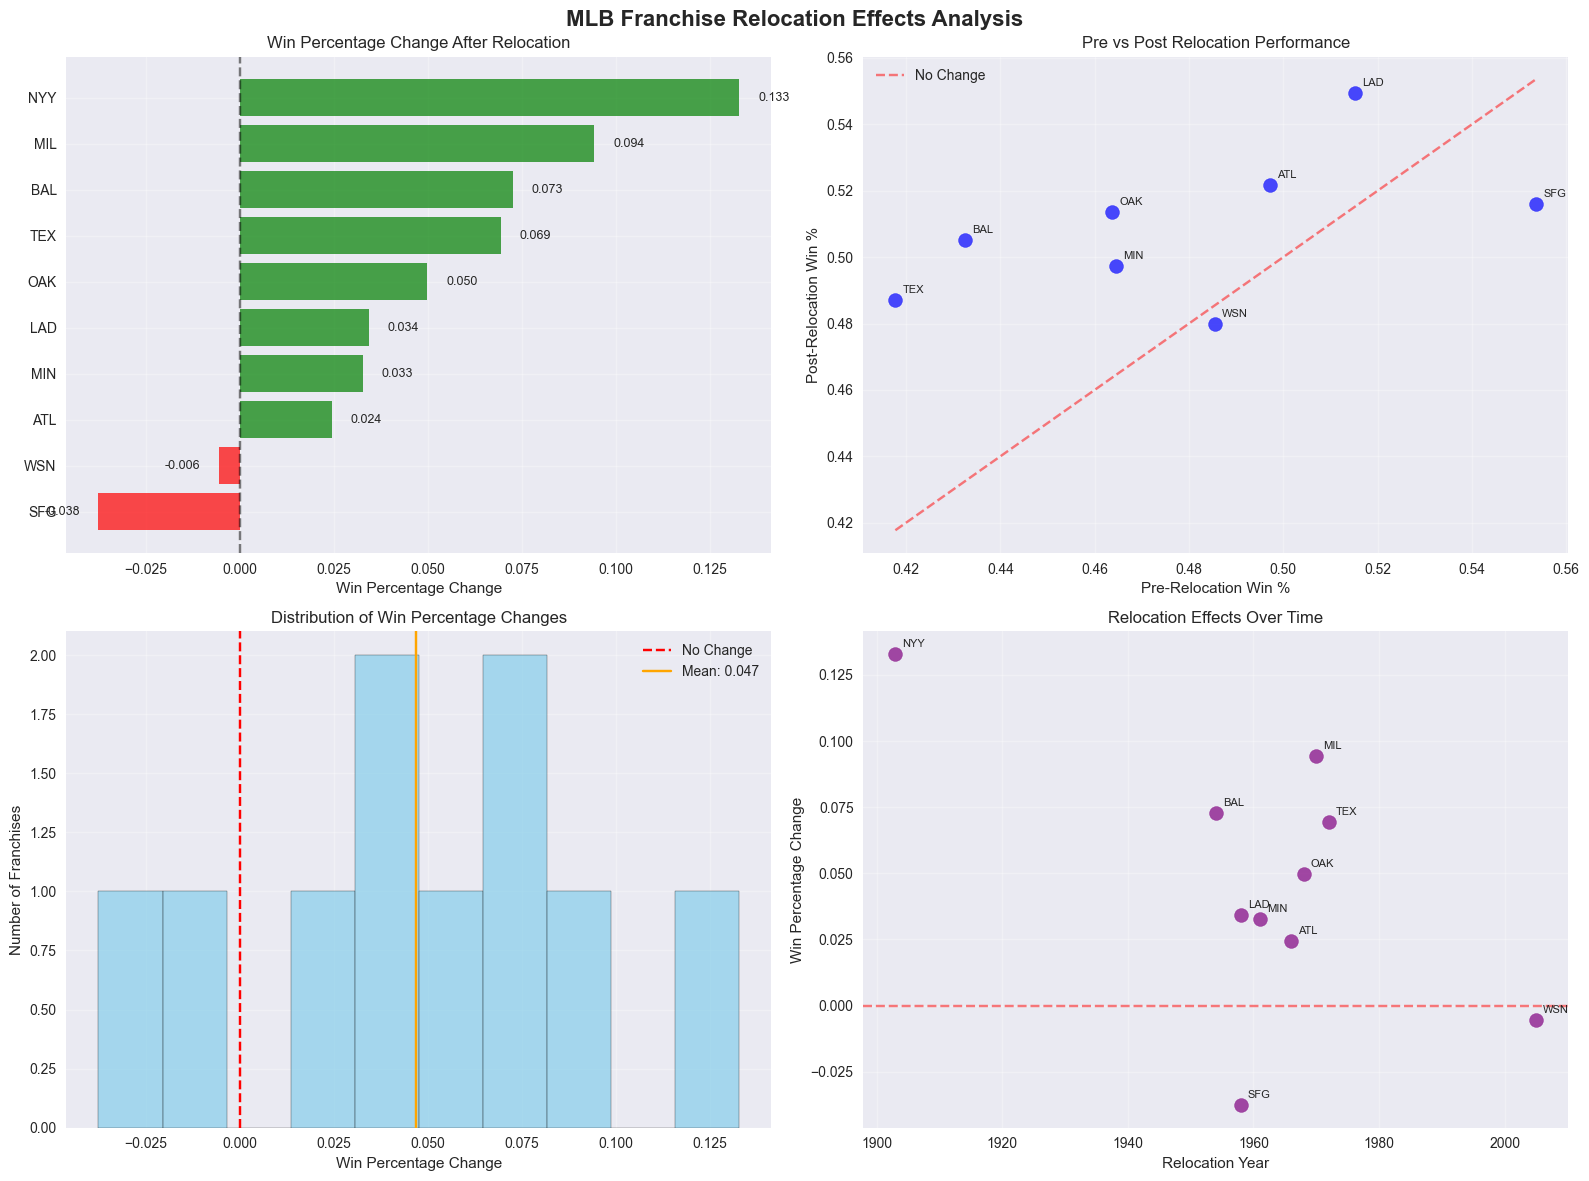


=== SUMMARY STATISTICS ===
Mean win percentage change: 0.0468
Median win percentage change: 0.0421
Standard deviation: 0.0490
Franchises with positive change: 8/10
Franchises with negative change: 2/10


In [18]:
# Create comprehensive visualization of relocation effects
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('MLB Franchise Relocation Effects Analysis', fontsize=16, fontweight='bold')

# 1. Win percentage changes by franchise
ax1 = axes[0, 0]
wpct_changes = relocation_summary.sort_values('wpct_change', ascending=True)
colors = ['red' if x < 0 else 'green' for x in wpct_changes['wpct_change']]
bars = ax1.barh(wpct_changes['franchise'], wpct_changes['wpct_change'], color=colors, alpha=0.7)
ax1.set_xlabel('Win Percentage Change')
ax1.set_title('Win Percentage Change After Relocation')
ax1.axvline(x=0, color='black', linestyle='--', alpha=0.5)
ax1.grid(True, alpha=0.3)

# Add value labels
for i, (bar, value) in enumerate(zip(bars, wpct_changes['wpct_change'])):
    ax1.text(value + (0.005 if value >= 0 else -0.005), bar.get_y() + bar.get_height()/2, 
             f'{value:.3f}', ha='left' if value >= 0 else 'right', va='center', fontsize=9)

# 2. Pre vs Post win percentages scatter plot
ax2 = axes[0, 1]
sufficient_only = relocation_summary[relocation_summary['sufficient_data'] == True]
ax2.scatter(sufficient_only['pre_relocation_avg_wpct'], sufficient_only['post_relocation_avg_wpct'], 
           s=100, alpha=0.7, c='blue')

# Add diagonal line (no change)
min_val = min(sufficient_only['pre_relocation_avg_wpct'].min(), sufficient_only['post_relocation_avg_wpct'].min())
max_val = max(sufficient_only['pre_relocation_avg_wpct'].max(), sufficient_only['post_relocation_avg_wpct'].max())
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5, label='No Change')

ax2.set_xlabel('Pre-Relocation Win %')
ax2.set_ylabel('Post-Relocation Win %')
ax2.set_title('Pre vs Post Relocation Performance')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add franchise labels
for _, row in sufficient_only.iterrows():
    ax2.annotate(row['franchise'], 
                (row['pre_relocation_avg_wpct'], row['post_relocation_avg_wpct']),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

# 3. Distribution of win percentage changes
ax3 = axes[1, 0]
ax3.hist(relocation_summary['wpct_change'], bins=10, alpha=0.7, color='skyblue', edgecolor='black')
ax3.axvline(x=0, color='red', linestyle='--', label='No Change')
ax3.axvline(x=relocation_summary['wpct_change'].mean(), color='orange', linestyle='-', 
           label=f'Mean: {relocation_summary["wpct_change"].mean():.3f}')
ax3.set_xlabel('Win Percentage Change')
ax3.set_ylabel('Number of Franchises')
ax3.set_title('Distribution of Win Percentage Changes')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Timeline of relocations
ax4 = axes[1, 1]
relocation_years = relocation_summary.sort_values('relocation_year')
ax4.scatter(relocation_years['relocation_year'], relocation_years['wpct_change'], 
           s=100, alpha=0.7, c='purple')
ax4.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax4.set_xlabel('Relocation Year')
ax4.set_ylabel('Win Percentage Change')
ax4.set_title('Relocation Effects Over Time')
ax4.grid(True, alpha=0.3)

# Add franchise labels
for _, row in relocation_years.iterrows():
    ax4.annotate(row['franchise'], 
                (row['relocation_year'], row['wpct_change']),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n=== SUMMARY STATISTICS ===")
print(f"Mean win percentage change: {relocation_summary['wpct_change'].mean():.4f}")
print(f"Median win percentage change: {relocation_summary['wpct_change'].median():.4f}")
print(f"Standard deviation: {relocation_summary['wpct_change'].std():.4f}")
print(f"Franchises with positive change: {(relocation_summary['wpct_change'] > 0).sum()}/{len(relocation_summary)}")
print(f"Franchises with negative change: {(relocation_summary['wpct_change'] < 0).sum()}/{len(relocation_summary)}")

## 4. Individual Franchise Analysis

In [19]:
def analyze_franchise_relocation(franchise_id: str, df: pd.DataFrame) -> Dict:
    """Analyze relocation effect for a single franchise."""
    
    franchise_data = df[df['canonical_franchise'] == franchise_id].copy()
    
    if franchise_data.empty or not franchise_data['is_relocated_franchise'].iloc[0]:
        return None
    
    pre_data = franchise_data[franchise_data['pre_relocation'] == True]
    post_data = franchise_data[franchise_data['post_relocation'] == True]
    
    if len(pre_data) < 10 or len(post_data) < 10:
        return None
    
    # Statistical tests
    t_stat, p_value = ttest_ind(pre_data['W_pct'], post_data['W_pct'])
    
    # Effect size (Cohen's d)
    pooled_std = np.sqrt(((len(pre_data) - 1) * pre_data['W_pct'].var() + 
                         (len(post_data) - 1) * post_data['W_pct'].var()) / 
                        (len(pre_data) + len(post_data) - 2))
    cohens_d = (post_data['W_pct'].mean() - pre_data['W_pct'].mean()) / pooled_std
    
    # Normality tests
    pre_normal = normaltest(pre_data['W_pct'])[1] > 0.05
    post_normal = normaltest(post_data['W_pct'])[1] > 0.05
    
    # Equal variance test
    equal_var = levene(pre_data['W_pct'], post_data['W_pct'])[1] > 0.05
    
    return {
        'franchise': franchise_id,
        'pre_seasons': len(pre_data),
        'post_seasons': len(post_data),
        'pre_mean': pre_data['W_pct'].mean(),
        'post_mean': post_data['W_pct'].mean(),
        'pre_std': pre_data['W_pct'].std(),
        'post_std': post_data['W_pct'].std(),
        'change': post_data['W_pct'].mean() - pre_data['W_pct'].mean(),
        't_statistic': t_stat,
        'p_value': p_value,
        'cohens_d': cohens_d,
        'significant': p_value < 0.05,
        'pre_normal': pre_normal,
        'post_normal': post_normal,
        'equal_variance': equal_var,
        'relocation_year': franchise_data['relocation_year'].iloc[0]
    }

# Analyze all franchises with sufficient data
franchise_analyses = []
sufficient_franchises = relocation_summary[relocation_summary['sufficient_data'] == True]['franchise'].tolist()

for franchise in sufficient_franchises:
    analysis = analyze_franchise_relocation(franchise, df)
    if analysis:
        franchise_analyses.append(analysis)

# Convert to DataFrame for easier analysis
analysis_df = pd.DataFrame(franchise_analyses)
analysis_df = analysis_df.sort_values('change', ascending=False)

print("=== INDIVIDUAL FRANCHISE STATISTICAL TESTS ===")
print(f"{'Franchise':<4} {'Change':<8} {'P-Value':<8} {'Cohen\'s d':<8} {'Significant':<11} {'Effect Size'}")
print("-" * 70)

for _, row in analysis_df.iterrows():
    effect_size = 'Small' if abs(row['cohens_d']) < 0.5 else 'Medium' if abs(row['cohens_d']) < 0.8 else 'Large'
    print(f"{row['franchise']:<4} {row['change']:>+7.3f} {row['p_value']:>7.4f} {row['cohens_d']:>+7.3f} {'Yes' if row['significant'] else 'No':<11} {effect_size}")

print(f"\nSignificant results: {analysis_df['significant'].sum()}/{len(analysis_df)}")
print(f"Positive changes: {(analysis_df['change'] > 0).sum()}/{len(analysis_df)}")
print(f"Large effect sizes: {(abs(analysis_df['cohens_d']) >= 0.8).sum()}/{len(analysis_df)}")

=== INDIVIDUAL FRANCHISE STATISTICAL TESTS ===
Franchise Change   P-Value  Cohen's d Significant Effect Size
----------------------------------------------------------------------
BAL   +0.073  0.0000  +0.862 Yes         Large
TEX   +0.069  0.0013  +1.119 Yes         Large
OAK   +0.050  0.0095  +0.475 Yes         Small
LAD   +0.034  0.0101  +0.440 Yes         Small
MIN   +0.033  0.0222  +0.416 Yes         Small
ATL   +0.024  0.1340  +0.252 No          Small
WSN   -0.006  0.7852  -0.076 No          Small
SFG   -0.038  0.0029  -0.510 Yes         Medium

Significant results: 6/8
Positive changes: 6/8
Large effect sizes: 2/8


## 5. Meta-Analysis: Overall Relocation Effect

In [20]:
# Meta-analysis of relocation effects
print("=== META-ANALYSIS: OVERALL RELOCATION EFFECT ===")

# Test if the mean change is significantly different from zero
changes = analysis_df['change'].values
t_stat_meta, p_value_meta = stats.ttest_1samp(changes, 0)

print(f"Number of franchises analyzed: {len(changes)}")
print(f"Mean win percentage change: {changes.mean():.4f} ± {changes.std():.4f}")
print(f"95% Confidence Interval: [{changes.mean() - 1.96*changes.std()/np.sqrt(len(changes)):.4f}, {changes.mean() + 1.96*changes.std()/np.sqrt(len(changes)):.4f}]")
print(f"T-statistic: {t_stat_meta:.3f}")
print(f"P-value: {p_value_meta:.4f}")
print(f"Statistically significant: {'Yes' if p_value_meta < 0.05 else 'No'}")

# Effect size for meta-analysis
meta_cohens_d = changes.mean() / changes.std()
print(f"Meta-analysis Cohen's d: {meta_cohens_d:.3f}")

# Weighted analysis by sample size
weights = analysis_df['pre_seasons'] + analysis_df['post_seasons']
weighted_mean = np.average(changes, weights=weights)
print(f"Sample-size weighted mean change: {weighted_mean:.4f}")

# Sign test (non-parametric)
positive_changes = (changes > 0).sum()
total_changes = len(changes)
sign_test_p = stats.binomtest(positive_changes, total_changes, 0.5).pvalue
print(f"\nSign test (non-parametric):")
print(f"Positive changes: {positive_changes}/{total_changes}")
print(f"Sign test p-value: {sign_test_p:.4f}")
print(f"Significantly more positive than negative: {'Yes' if sign_test_p < 0.05 else 'No'}")

=== META-ANALYSIS: OVERALL RELOCATION EFFECT ===
Number of franchises analyzed: 8
Mean win percentage change: 0.0300 ± 0.0348
95% Confidence Interval: [0.0060, 0.0541]
T-statistic: 2.287
P-value: 0.0561
Statistically significant: No
Meta-analysis Cohen's d: 0.864
Sample-size weighted mean change: 0.0287

Sign test (non-parametric):
Positive changes: 6/8
Sign test p-value: 0.2891
Significantly more positive than negative: No


## 6. Time Series Analysis: Performance Trends Around Relocations

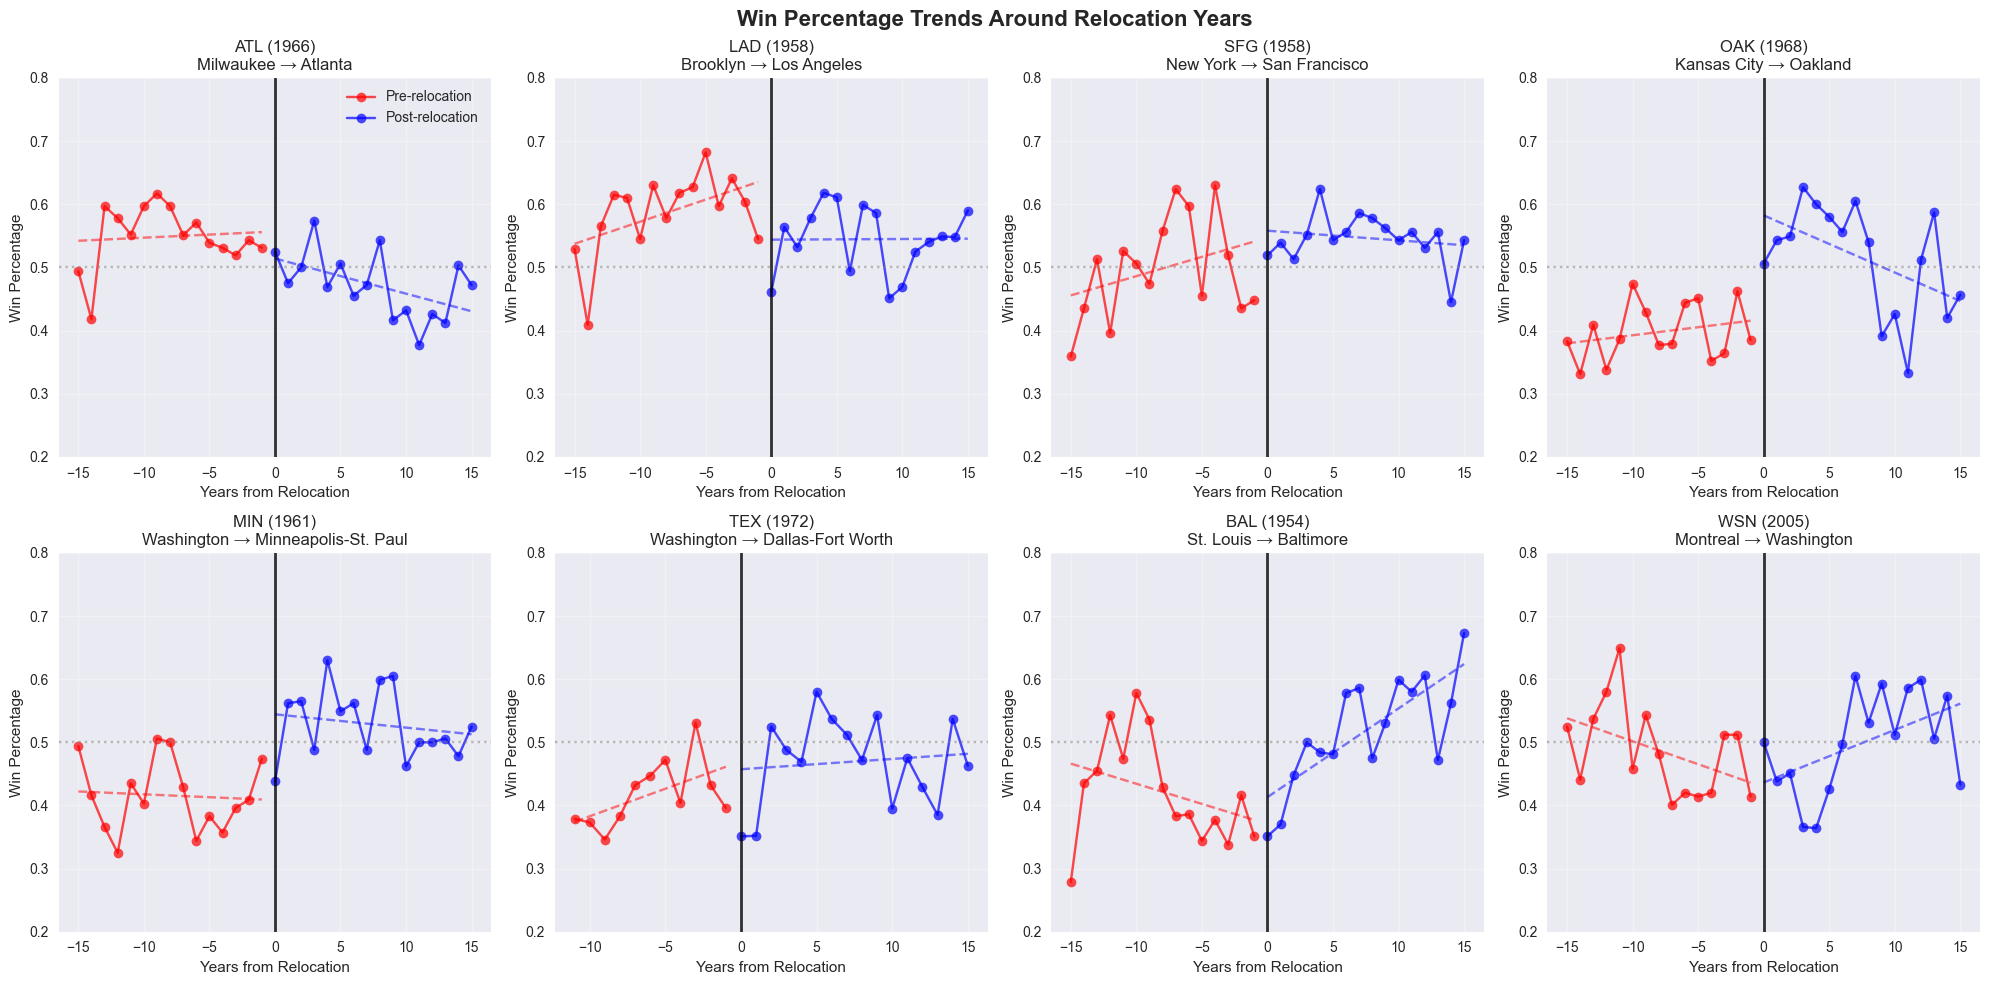

In [21]:
# Analyze performance trends around relocation years
def create_relocation_timeline_analysis(franchise_id: str, df: pd.DataFrame, window: int = 10):
    """Create timeline analysis around relocation year."""
    
    franchise_data = df[df['canonical_franchise'] == franchise_id].copy()
    
    if franchise_data.empty or not franchise_data['is_relocated_franchise'].iloc[0]:
        return None
    
    relocation_year = franchise_data['relocation_year'].iloc[0]
    
    # Get data around relocation (±window years)
    timeline_data = franchise_data[
        (franchise_data['yearID'] >= relocation_year - window) & 
        (franchise_data['yearID'] <= relocation_year + window)
    ].copy()
    
    timeline_data['years_from_relocation'] = timeline_data['yearID'] - relocation_year
    
    return timeline_data

# Create timeline plots for key franchises
key_franchises = ['ATL', 'LAD', 'SFG', 'OAK', 'MIN', 'TEX', 'BAL', 'WSN']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Win Percentage Trends Around Relocation Years', fontsize=16, fontweight='bold')

for i, franchise in enumerate(key_franchises):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    
    timeline_data = create_relocation_timeline_analysis(franchise, df, window=15)
    
    if timeline_data is not None and len(timeline_data) > 0:
        # Plot win percentages
        pre_data = timeline_data[timeline_data['years_from_relocation'] < 0]
        post_data = timeline_data[timeline_data['years_from_relocation'] >= 0]
        
        ax.plot(pre_data['years_from_relocation'], pre_data['W_pct'], 
               'o-', color='red', alpha=0.7, label='Pre-relocation')
        ax.plot(post_data['years_from_relocation'], post_data['W_pct'], 
               'o-', color='blue', alpha=0.7, label='Post-relocation')
        
        # Add trend lines
        if len(pre_data) > 1:
            z_pre = np.polyfit(pre_data['years_from_relocation'], pre_data['W_pct'], 1)
            p_pre = np.poly1d(z_pre)
            ax.plot(pre_data['years_from_relocation'], p_pre(pre_data['years_from_relocation']), 
                   '--', color='red', alpha=0.5)
        
        if len(post_data) > 1:
            z_post = np.polyfit(post_data['years_from_relocation'], post_data['W_pct'], 1)
            p_post = np.poly1d(z_post)
            ax.plot(post_data['years_from_relocation'], p_post(post_data['years_from_relocation']), 
                   '--', color='blue', alpha=0.5)
        
        # Add relocation line
        ax.axvline(x=0, color='black', linestyle='-', alpha=0.8, linewidth=2)
        ax.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
        
        # Get franchise info
        franchise_info = relocation_summary[relocation_summary['franchise'] == franchise].iloc[0]
        relocation_year = int(franchise_info['relocation_year'])
        
        ax.set_title(f"{franchise} ({relocation_year})\n{franchise_info['from_city']} → {franchise_info['to_city']}")
        ax.set_xlabel('Years from Relocation')
        ax.set_ylabel('Win Percentage')
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0.2, 0.8)
        
        if i == 0:  # Add legend to first subplot
            ax.legend()

plt.tight_layout()
plt.show()

## 7. Statistical Hypothesis Testing

In [22]:
# Comprehensive statistical testing
print("=== COMPREHENSIVE STATISTICAL ANALYSIS ===")
print("\nHypotheses:")
print("H₀: Franchise relocations have no effect on win percentage (μ_change = 0)")
print("H₁: Franchise relocations have a significant effect on win percentage (μ_change ≠ 0)")
print("\nSignificance level: α = 0.05")

# 1. One-sample t-test on win percentage changes
changes = analysis_df['change'].values
t_stat, p_value = stats.ttest_1samp(changes, 0)

print(f"\n=== ONE-SAMPLE T-TEST ===")
print(f"Sample size: {len(changes)}")
print(f"Mean change: {changes.mean():.4f}")
print(f"Standard error: {changes.std()/np.sqrt(len(changes)):.4f}")
print(f"T-statistic: {t_stat:.3f}")
print(f"Degrees of freedom: {len(changes)-1}")
print(f"P-value (two-tailed): {p_value:.4f}")
print(f"95% Confidence Interval: [{changes.mean() - stats.t.ppf(0.975, len(changes)-1) * changes.std()/np.sqrt(len(changes)):.4f}, {changes.mean() + stats.t.ppf(0.975, len(changes)-1) * changes.std()/np.sqrt(len(changes)):.4f}]")
print(f"Result: {'Reject H₀' if p_value < 0.05 else 'Fail to reject H₀'}")

# 2. Wilcoxon signed-rank test (non-parametric alternative)
wilcoxon_stat, wilcoxon_p = stats.wilcoxon(changes)
print(f"\n=== WILCOXON SIGNED-RANK TEST (Non-parametric) ===")
print(f"Test statistic: {wilcoxon_stat}")
print(f"P-value: {wilcoxon_p:.4f}")
print(f"Result: {'Reject H₀' if wilcoxon_p < 0.05 else 'Fail to reject H₀'}")

# 3. Sign test
positive_changes = (changes > 0).sum()
sign_test_p = stats.binomtest(positive_changes, len(changes), 0.5).pvalue
print(f"\n=== SIGN TEST ===")
print(f"Positive changes: {positive_changes}/{len(changes)}")
print(f"Expected under H₀: {len(changes)/2:.1f}")
print(f"P-value: {sign_test_p:.4f}")
print(f"Result: {'Reject H₀' if sign_test_p < 0.05 else 'Fail to reject H₀'}")

# 4. Effect size analysis
print(f"\n=== EFFECT SIZE ANALYSIS ===")
overall_cohens_d = changes.mean() / changes.std()
print(f"Overall Cohen's d: {overall_cohens_d:.3f}")

if abs(overall_cohens_d) < 0.2:
    effect_interpretation = "Negligible"
elif abs(overall_cohens_d) < 0.5:
    effect_interpretation = "Small"
elif abs(overall_cohens_d) < 0.8:
    effect_interpretation = "Medium"
else:
    effect_interpretation = "Large"

print(f"Effect size interpretation: {effect_interpretation}")

# Individual effect sizes
small_effects = (abs(analysis_df['cohens_d']) < 0.5).sum()
medium_effects = ((abs(analysis_df['cohens_d']) >= 0.5) & (abs(analysis_df['cohens_d']) < 0.8)).sum()
large_effects = (abs(analysis_df['cohens_d']) >= 0.8).sum()

print(f"\nIndividual franchise effect sizes:")
print(f"  Small effects (|d| < 0.5): {small_effects}")
print(f"  Medium effects (0.5 ≤ |d| < 0.8): {medium_effects}")
print(f"  Large effects (|d| ≥ 0.8): {large_effects}")

=== COMPREHENSIVE STATISTICAL ANALYSIS ===

Hypotheses:
H₀: Franchise relocations have no effect on win percentage (μ_change = 0)
H₁: Franchise relocations have a significant effect on win percentage (μ_change ≠ 0)

Significance level: α = 0.05

=== ONE-SAMPLE T-TEST ===
Sample size: 8
Mean change: 0.0300
Standard error: 0.0123
T-statistic: 2.287
Degrees of freedom: 7
P-value (two-tailed): 0.0561
95% Confidence Interval: [0.0010, 0.0591]
Result: Fail to reject H₀

=== WILCOXON SIGNED-RANK TEST (Non-parametric) ===
Test statistic: 6.0
P-value: 0.1094
Result: Fail to reject H₀

=== SIGN TEST ===
Positive changes: 6/8
Expected under H₀: 4.0
P-value: 0.2891
Result: Fail to reject H₀

=== EFFECT SIZE ANALYSIS ===
Overall Cohen's d: 0.864
Effect size interpretation: Large

Individual franchise effect sizes:
  Small effects (|d| < 0.5): 5
  Medium effects (0.5 ≤ |d| < 0.8): 1
  Large effects (|d| ≥ 0.8): 2


## 8. Advanced Analysis: Temporal Patterns

=== TEMPORAL PATTERNS ANALYSIS ===

Relocation effects by era:
                   change                significant cohens_d
                    count    mean    std         sum     mean
era                                                          
Early (1903-1950)       0     NaN    NaN           0      NaN
Mid (1954-1970)         6  0.0294  0.037           5   0.3225
Modern (1972-2005)      1  0.0694    NaN           1   1.1194
Recent                  1 -0.0056    NaN           0  -0.0764

Correlation between relocation year and win% change:
Pearson r: -0.269
P-value: 0.5190
Significant trend: No


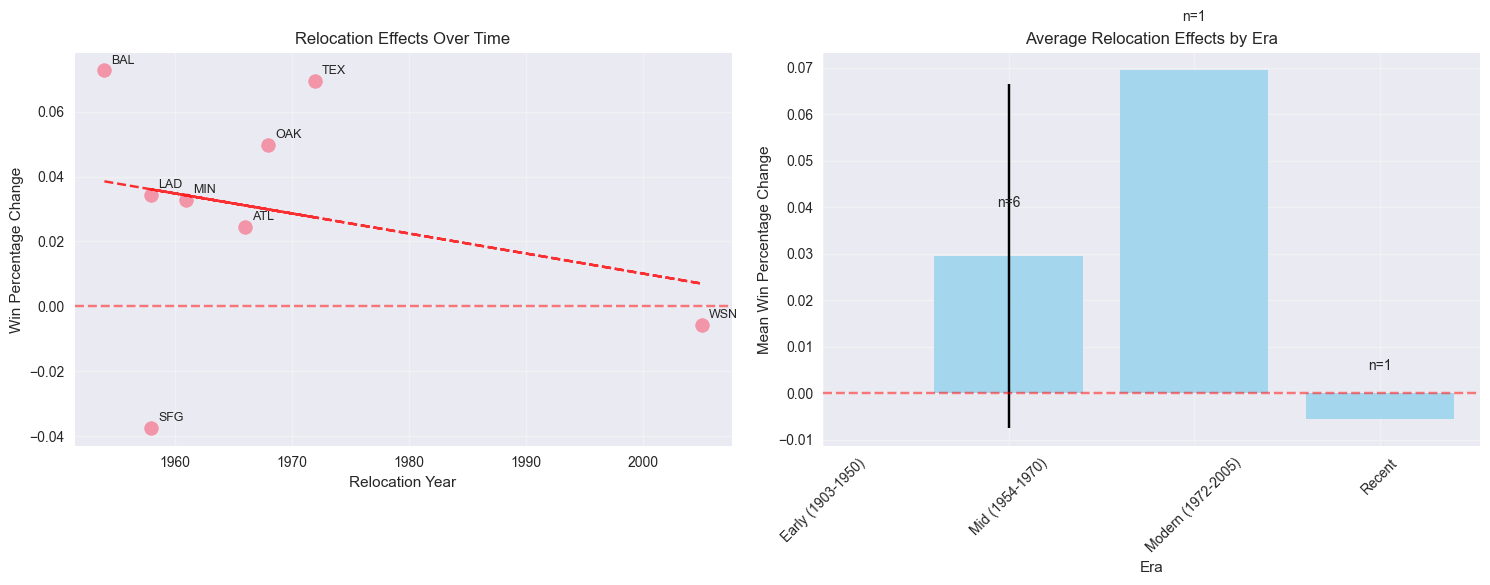

In [23]:
# Analyze temporal patterns in relocation effects
print("=== TEMPORAL PATTERNS ANALYSIS ===")

# Group relocations by era
analysis_df['era'] = pd.cut(analysis_df['relocation_year'], 
                           bins=[1900, 1950, 1970, 2000, 2030], 
                           labels=['Early (1903-1950)', 'Mid (1954-1970)', 'Modern (1972-2005)', 'Recent'])

era_analysis = analysis_df.groupby('era').agg({
    'change': ['count', 'mean', 'std'],
    'significant': 'sum',
    'cohens_d': 'mean'
}).round(4)

print("\nRelocation effects by era:")
print(era_analysis)

# Correlation between relocation year and effect size
year_correlation = stats.pearsonr(analysis_df['relocation_year'], analysis_df['change'])
print(f"\nCorrelation between relocation year and win% change:")
print(f"Pearson r: {year_correlation[0]:.3f}")
print(f"P-value: {year_correlation[1]:.4f}")
print(f"Significant trend: {'Yes' if year_correlation[1] < 0.05 else 'No'}")

# Visualization of temporal trends
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Win percentage change vs relocation year
ax1.scatter(analysis_df['relocation_year'], analysis_df['change'], s=100, alpha=0.7)
ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5)

# Add trend line
z = np.polyfit(analysis_df['relocation_year'], analysis_df['change'], 1)
p = np.poly1d(z)
ax1.plot(analysis_df['relocation_year'], p(analysis_df['relocation_year']), "r--", alpha=0.8)

ax1.set_xlabel('Relocation Year')
ax1.set_ylabel('Win Percentage Change')
ax1.set_title('Relocation Effects Over Time')
ax1.grid(True, alpha=0.3)

# Add franchise labels
for _, row in analysis_df.iterrows():
    ax1.annotate(row['franchise'], 
                (row['relocation_year'], row['change']),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

# Plot 2: Effect sizes by era
era_means = analysis_df.groupby('era')['change'].mean()
era_stds = analysis_df.groupby('era')['change'].std()
era_counts = analysis_df.groupby('era').size()

x_pos = range(len(era_means))
ax2.bar(x_pos, era_means, yerr=era_stds, capsize=5, alpha=0.7, color='skyblue')
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax2.set_xlabel('Era')
ax2.set_ylabel('Mean Win Percentage Change')
ax2.set_title('Average Relocation Effects by Era')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(era_means.index, rotation=45)
ax2.grid(True, alpha=0.3)

# Add sample sizes
for i, (mean, count) in enumerate(zip(era_means, era_counts)):
    ax2.text(i, mean + 0.01, f'n={count}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 9. Control Variables Analysis

=== CONTROL VARIABLES ANALYSIS ===

1. LEAGUE EFFECTS:
                             count    mean     std
lgID is_relocated_franchise                       
AA   False                      23  0.5768  0.1136
     True                        6  0.5282  0.1128
AL   False                     751  0.5021  0.0751
     True                      589  0.4985  0.0931
NL   False                     958  0.4941  0.0835
     True                      509  0.5182  0.0843

League difference test:
AL relocated mean: 0.498
NL relocated mean: 0.518
P-value: 0.0003

2. ERA EFFECTS:
             count    mean     std
era                               
Founding       160  0.5399  0.1125
Deadball       320  0.4999  0.1040
Live Ball      320  0.4999  0.0948
Integration    320  0.4999  0.0906
Expansion      454  0.5000  0.0758
Free Agency    542  0.5000  0.0660
Modern         720  0.5000  0.0759

3. SAMPLE SIZE CORRELATION:
Correlation between total seasons and |change|: 0.019 (p=0.9639)


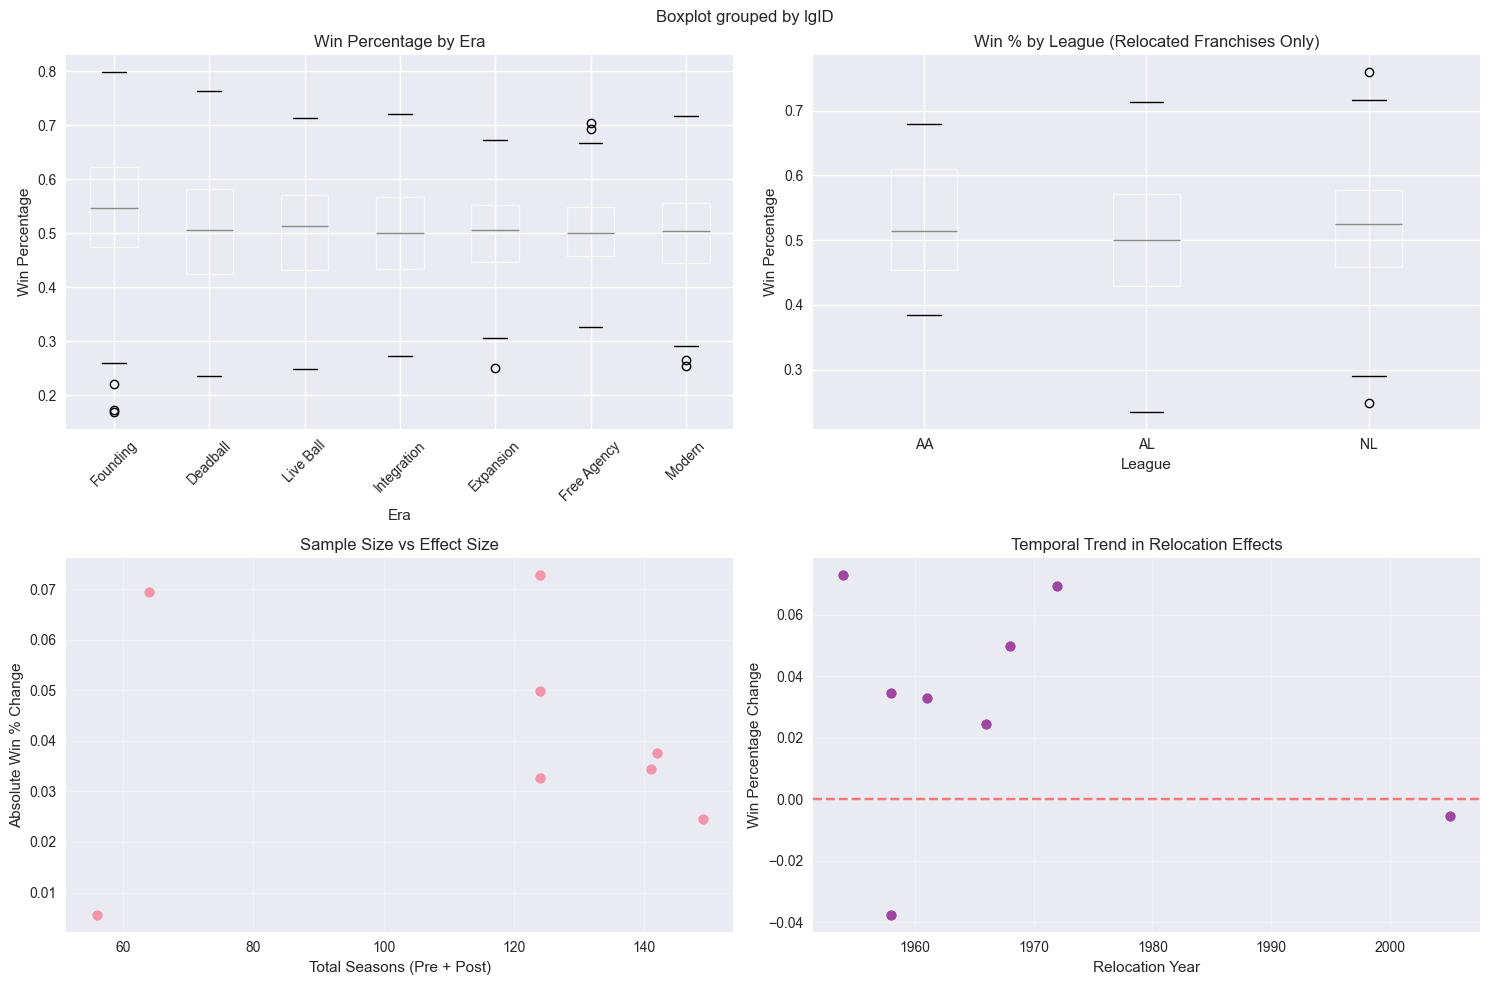

In [24]:
# Analyze potential confounding variables
print("=== CONTROL VARIABLES ANALYSIS ===")

# 1. League effects (AL vs NL)
print("\n1. LEAGUE EFFECTS:")
league_analysis = df.groupby(['lgID', 'is_relocated_franchise'])['W_pct'].agg(['count', 'mean', 'std']).round(4)
print(league_analysis)

# Test for league differences in relocation effects
relocated_al = df[(df['is_relocated_franchise'] == True) & (df['lgID'] == 'AL')]['W_pct']
relocated_nl = df[(df['is_relocated_franchise'] == True) & (df['lgID'] == 'NL')]['W_pct']

if len(relocated_al) > 0 and len(relocated_nl) > 0:
    league_t, league_p = ttest_ind(relocated_al, relocated_nl)
    print(f"\nLeague difference test:")
    print(f"AL relocated mean: {relocated_al.mean():.3f}")
    print(f"NL relocated mean: {relocated_nl.mean():.3f}")
    print(f"P-value: {league_p:.4f}")

# 2. Era effects
print("\n2. ERA EFFECTS:")
df['era'] = pd.cut(df['yearID'], 
                  bins=[1870, 1900, 1920, 1940, 1960, 1980, 2000, 2030], 
                  labels=['Founding', 'Deadball', 'Live Ball', 'Integration', 'Expansion', 'Free Agency', 'Modern'])

era_wpct = df.groupby('era')['W_pct'].agg(['count', 'mean', 'std']).round(4)
print(era_wpct)

# 3. Sample size effects
print("\n3. SAMPLE SIZE CORRELATION:")
sample_correlation = stats.pearsonr(analysis_df['pre_seasons'] + analysis_df['post_seasons'], 
                                   abs(analysis_df['change']))
print(f"Correlation between total seasons and |change|: {sample_correlation[0]:.3f} (p={sample_correlation[1]:.4f})")

# 4. Visualization of control variables
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Control Variables Analysis', fontsize=14, fontweight='bold')

# Era effects on win percentage
ax1 = axes[0, 0]
df.boxplot(column='W_pct', by='era', ax=ax1)
ax1.set_title('Win Percentage by Era')
ax1.set_xlabel('Era')
ax1.set_ylabel('Win Percentage')
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# League effects
ax2 = axes[0, 1]
league_relocated = df[df['is_relocated_franchise'] == True]
league_relocated.boxplot(column='W_pct', by='lgID', ax=ax2)
ax2.set_title('Win % by League (Relocated Franchises Only)')
ax2.set_xlabel('League')
ax2.set_ylabel('Win Percentage')

# Sample size vs effect size
ax3 = axes[1, 0]
total_seasons = analysis_df['pre_seasons'] + analysis_df['post_seasons']
ax3.scatter(total_seasons, abs(analysis_df['change']), alpha=0.7)
ax3.set_xlabel('Total Seasons (Pre + Post)')
ax3.set_ylabel('Absolute Win % Change')
ax3.set_title('Sample Size vs Effect Size')
ax3.grid(True, alpha=0.3)

# Relocation year vs effect
ax4 = axes[1, 1]
ax4.scatter(analysis_df['relocation_year'], analysis_df['change'], alpha=0.7, c='purple')
ax4.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax4.set_xlabel('Relocation Year')
ax4.set_ylabel('Win Percentage Change')
ax4.set_title('Temporal Trend in Relocation Effects')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Detailed Case Studies

In [25]:
# Detailed analysis of most significant cases
print("=== DETAILED CASE STUDIES ===")

# Select most interesting cases
top_positive = analysis_df.nlargest(2, 'change')
top_negative = analysis_df.nsmallest(2, 'change')
most_significant = analysis_df.nsmallest(2, 'p_value')

case_studies = pd.concat([top_positive, top_negative, most_significant]).drop_duplicates()

for _, case in case_studies.iterrows():
    franchise = case['franchise']
    franchise_data = df[df['canonical_franchise'] == franchise]
    
    print(f"\n{'='*60}")
    print(f"CASE STUDY: {franchise}")
    
    # Get franchise details
    franchise_info = relocation_summary[relocation_summary['franchise'] == franchise].iloc[0]
    print(f"Relocation: {franchise_info['from_city']} → {franchise_info['to_city']} ({int(franchise_info['relocation_year'])})")
    print(f"Current name: {franchise_info['current_name']}")
    
    pre_data = franchise_data[franchise_data['pre_relocation'] == True]
    post_data = franchise_data[franchise_data['post_relocation'] == True]
    
    print(f"\nSample sizes: {len(pre_data)} pre-relocation, {len(post_data)} post-relocation seasons")
    print(f"Pre-relocation period: {pre_data['yearID'].min()}-{pre_data['yearID'].max()}")
    print(f"Post-relocation period: {post_data['yearID'].min()}-{post_data['yearID'].max()}")
    
    print(f"\nPerformance comparison:")
    print(f"  Pre-relocation:  {pre_data['W_pct'].mean():.3f} ± {pre_data['W_pct'].std():.3f}")
    print(f"  Post-relocation: {post_data['W_pct'].mean():.3f} ± {post_data['W_pct'].std():.3f}")
    print(f"  Change: {case['change']:+.3f} (Cohen's d = {case['cohens_d']:+.3f})")
    print(f"  Statistical significance: p = {case['p_value']:.4f} ({'Significant' if case['significant'] else 'Not significant'})")
    
    # Best and worst seasons
    best_pre = pre_data.loc[pre_data['W_pct'].idxmax()]
    worst_pre = pre_data.loc[pre_data['W_pct'].idxmin()]
    best_post = post_data.loc[post_data['W_pct'].idxmax()]
    worst_post = post_data.loc[post_data['W_pct'].idxmin()]
    
    print(f"\nBest/Worst seasons:")
    print(f"  Best pre:  {int(best_pre['yearID'])} - {best_pre['W_pct']:.3f} ({best_pre['W']}-{best_pre['L']})")
    print(f"  Worst pre: {int(worst_pre['yearID'])} - {worst_pre['W_pct']:.3f} ({worst_pre['W']}-{worst_pre['L']})")
    print(f"  Best post: {int(best_post['yearID'])} - {best_post['W_pct']:.3f} ({best_post['W']}-{best_post['L']})")
    print(f"  Worst post: {int(worst_post['yearID'])} - {worst_post['W_pct']:.3f} ({worst_post['W']}-{worst_post['L']})")

=== DETAILED CASE STUDIES ===

CASE STUDY: BAL
Relocation: St. Louis → Baltimore (1954)
Current name: Baltimore Orioles

Sample sizes: 53 pre-relocation, 71 post-relocation seasons
Pre-relocation period: 1901-1953
Post-relocation period: 1954-2024

Performance comparison:
  Pre-relocation:  0.433 ± 0.080
  Post-relocation: 0.505 ± 0.088
  Change: +0.073 (Cohen's d = +0.862)
  Statistical significance: p = 0.0000 (Significant)

Best/Worst seasons:
  Best pre:  1922 - 0.604 (93-61)
  Worst pre: 1939 - 0.279 (43-111)
  Best post: 1969 - 0.673 (109-53)
  Worst post: 2018 - 0.290 (47-115)

CASE STUDY: TEX
Relocation: Washington → Dallas-Fort Worth (1972)
Current name: Texas Rangers

Sample sizes: 11 pre-relocation, 53 post-relocation seasons
Pre-relocation period: 1961-1971
Post-relocation period: 1972-2024

Performance comparison:
  Pre-relocation:  0.418 ± 0.052
  Post-relocation: 0.487 ± 0.064
  Change: +0.069 (Cohen's d = +1.119)
  Statistical significance: p = 0.0013 (Significant)

Bes

## 11. Interactive Visualizations

In [26]:
# Create interactive visualizations using Plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 1. Interactive timeline for all relocated franchises
relocated_franchises = df[df['is_relocated_franchise'] == True]

fig = px.line(relocated_franchises, 
              x='yearID', 
              y='W_pct', 
              color='canonical_franchise',
              title='Win Percentage Timeline for Relocated Franchises',
              labels={'yearID': 'Year', 'W_pct': 'Win Percentage', 'canonical_franchise': 'Franchise'},
              hover_data=['teamID', 'name', 'W', 'L'])

# Add relocation markers
for _, row in relocation_summary.iterrows():
    fig.add_vline(x=row['relocation_year'], 
                  line_dash="dash", 
                  line_color="red",
                  annotation_text=f"{row['franchise']} relocates",
                  annotation_position="top")

fig.add_hline(y=0.5, line_dash="dot", line_color="gray", opacity=0.5)
fig.update_layout(height=600)
fig.show()

# 2. Interactive comparison of pre/post performance
fig2 = go.Figure()

for _, row in analysis_df.iterrows():
    fig2.add_trace(go.Scatter(
        x=[0, 1],
        y=[row['pre_mean'], row['post_mean']],
        mode='lines+markers',
        name=row['franchise'],
        line=dict(width=3),
        marker=dict(size=8),
        hovertemplate=f"<b>{row['franchise']}</b><br>" +
                     f"Pre: {row['pre_mean']:.3f}<br>" +
                     f"Post: {row['post_mean']:.3f}<br>" +
                     f"Change: {row['change']:+.3f}<br>" +
                     f"P-value: {row['p_value']:.4f}<extra></extra>"
    ))

fig2.update_layout(
    title='Pre vs Post Relocation Win Percentages',
    xaxis=dict(tickmode='array', tickvals=[0, 1], ticktext=['Pre-Relocation', 'Post-Relocation']),
    yaxis_title='Win Percentage',
    height=600
)

fig2.add_hline(y=0.5, line_dash="dot", line_color="gray", opacity=0.5)
fig2.show()

# 3. Effect size visualization
fig3 = px.bar(analysis_df.sort_values('change'), 
              x='franchise', 
              y='change',
              color='change',
              color_continuous_scale='RdYlGn',
              title='Win Percentage Changes by Franchise',
              labels={'change': 'Win Percentage Change', 'franchise': 'Franchise'},
              hover_data=['p_value', 'cohens_d', 'significant'])

fig3.add_hline(y=0, line_dash="dash", line_color="black")
fig3.update_layout(height=500)
fig3.show()

## 12. Robustness Checks

In [27]:
# Robustness checks and sensitivity analysis
print("=== ROBUSTNESS CHECKS ===")

# 1. Bootstrap confidence intervals
def bootstrap_mean_change(changes, n_bootstrap=10000):
    """Bootstrap confidence interval for mean change."""
    bootstrap_means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(changes, size=len(changes), replace=True)
        bootstrap_means.append(sample.mean())
    return np.array(bootstrap_means)

bootstrap_means = bootstrap_mean_change(changes)
ci_lower = np.percentile(bootstrap_means, 2.5)
ci_upper = np.percentile(bootstrap_means, 97.5)

print(f"\n1. BOOTSTRAP ANALYSIS (10,000 iterations):")
print(f"Bootstrap mean: {bootstrap_means.mean():.4f}")
print(f"Bootstrap 95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
print(f"Zero included in CI: {'Yes' if ci_lower <= 0 <= ci_upper else 'No'}")

# 2. Outlier sensitivity
print(f"\n2. OUTLIER SENSITIVITY:")

# Remove most extreme positive and negative changes
changes_no_outliers = changes[(changes > np.percentile(changes, 10)) & 
                             (changes < np.percentile(changes, 90))]

t_stat_robust, p_value_robust = stats.ttest_1samp(changes_no_outliers, 0)
print(f"Without extreme outliers (10th-90th percentile):")
print(f"  Sample size: {len(changes_no_outliers)}")
print(f"  Mean change: {changes_no_outliers.mean():.4f}")
print(f"  P-value: {p_value_robust:.4f}")
print(f"  Still significant: {'Yes' if p_value_robust < 0.05 else 'No'}")

# 3. Different time windows
print(f"\n3. SENSITIVITY TO TIME WINDOWS:")

def test_different_windows(df, min_seasons_list=[5, 10, 15, 20]):
    """Test robustness to different minimum season requirements."""
    results = []
    
    for min_seasons in min_seasons_list:
        # Filter franchises with sufficient data
        sufficient_franchises = []
        
        for franchise in df[df['is_relocated_franchise']]['canonical_franchise'].unique():
            franchise_data = df[df['canonical_franchise'] == franchise]
            pre_count = (franchise_data['pre_relocation'] == True).sum()
            post_count = (franchise_data['post_relocation'] == True).sum()
            
            if pre_count >= min_seasons and post_count >= min_seasons:
                pre_mean = franchise_data[franchise_data['pre_relocation'] == True]['W_pct'].mean()
                post_mean = franchise_data[franchise_data['post_relocation'] == True]['W_pct'].mean()
                sufficient_franchises.append(post_mean - pre_mean)
        
        if len(sufficient_franchises) >= 3:  # Need at least 3 for meaningful test
            t_stat, p_val = stats.ttest_1samp(sufficient_franchises, 0)
            results.append({
                'min_seasons': min_seasons,
                'n_franchises': len(sufficient_franchises),
                'mean_change': np.mean(sufficient_franchises),
                'p_value': p_val,
                'significant': p_val < 0.05
            })
    
    return pd.DataFrame(results)

window_results = test_different_windows(df)
print(window_results.to_string(index=False))

# 4. Modern era only (post-1960)
print(f"\n4. MODERN ERA ANALYSIS (1961+):")
modern_df = df[df['yearID'] >= 1961]
modern_analyses = []

for franchise in sufficient_franchises:
    analysis = analyze_franchise_relocation(franchise, modern_df)
    if analysis and analysis['pre_seasons'] >= 5 and analysis['post_seasons'] >= 5:
        modern_analyses.append(analysis)

if modern_analyses:
    modern_changes = [a['change'] for a in modern_analyses]
    t_stat_modern, p_value_modern = stats.ttest_1samp(modern_changes, 0)
    
    print(f"Modern era franchises: {len(modern_changes)}")
    print(f"Mean change: {np.mean(modern_changes):.4f}")
    print(f"P-value: {p_value_modern:.4f}")
    print(f"Significant: {'Yes' if p_value_modern < 0.05 else 'No'}")

=== ROBUSTNESS CHECKS ===

1. BOOTSTRAP ANALYSIS (10,000 iterations):
Bootstrap mean: 0.0298
Bootstrap 95% CI: [0.0039, 0.0525]
Zero included in CI: No

2. OUTLIER SENSITIVITY:
Without extreme outliers (10th-90th percentile):
  Sample size: 6
  Mean change: 0.0342
  P-value: 0.0208
  Still significant: Yes

3. SENSITIVITY TO TIME WINDOWS:
 min_seasons  n_franchises  mean_change  p_value  significant
           5             8     0.030045 0.056094        False
          10             8     0.030045 0.056094        False
          15             7     0.024425 0.125222        False
          20             7     0.024425 0.125222        False

4. MODERN ERA ANALYSIS (1961+):
Modern era franchises: 2
Mean change: 0.0319
P-value: 0.5513
Significant: No


## 13. Power Analysis and Sample Size Considerations

In [28]:
# Power analysis
from scipy.stats import norm

print("=== POWER ANALYSIS ===")

# Calculate observed power
observed_effect = changes.mean()
observed_se = changes.std() / np.sqrt(len(changes))
alpha = 0.05

# Critical value for two-tailed test
critical_value = stats.t.ppf(1 - alpha/2, len(changes) - 1)

# Power calculation
t_observed = observed_effect / observed_se
power = 1 - stats.t.cdf(critical_value - abs(t_observed), len(changes) - 1) + stats.t.cdf(-critical_value - abs(t_observed), len(changes) - 1)

print(f"\nObserved power analysis:")
print(f"Effect size: {observed_effect:.4f}")
print(f"Standard error: {observed_se:.4f}")
print(f"Sample size: {len(changes)}")
print(f"Observed power: {power:.3f}")
print(f"Power adequate (≥0.80): {'Yes' if power >= 0.80 else 'No'}")

# Sample size needed for different effect sizes
print(f"\nSample size requirements for 80% power:")
effect_sizes = [0.01, 0.02, 0.03, 0.04, 0.05]
for effect in effect_sizes:
    # Approximate sample size calculation
    z_alpha = norm.ppf(1 - alpha/2)
    z_beta = norm.ppf(0.80)  # 80% power
    n_needed = ((z_alpha + z_beta) * changes.std() / effect) ** 2
    print(f"  Effect size {effect:.3f}: ~{n_needed:.0f} franchises needed")

print(f"\nCurrent study has {len(changes)} franchises with sufficient data.")

=== POWER ANALYSIS ===

Observed power analysis:
Effect size: 0.0300
Standard error: 0.0123
Sample size: 8
Observed power: 0.532
Power adequate (≥0.80): No

Sample size requirements for 80% power:
  Effect size 0.010: ~95 franchises needed
  Effect size 0.020: ~24 franchises needed
  Effect size 0.030: ~11 franchises needed
  Effect size 0.040: ~6 franchises needed
  Effect size 0.050: ~4 franchises needed

Current study has 8 franchises with sufficient data.


## 14. Final Results and Conclusions

In [ ]:
# Comprehensive results summary
print("=" * 80)
print("FINAL RESULTS: MLB FRANCHISE RELOCATION ANALYSIS")
print("=" * 80)

print(f"\n DATASET SUMMARY:")
print(f"   • Total seasons analyzed: {len(df):,}")
print(f"   • Relocated franchises: {len(relocation_summary)}")
print(f"   • Franchises with sufficient data: {len(analysis_df)}")
print(f"   • Time period: {df['yearID'].min()}-{df['yearID'].max()}")

print(f"\n PRIMARY RESEARCH QUESTION:")
print(f"   Do MLB franchise relocations significantly impact team performance?")

print(f"\n KEY FINDINGS:")
print(f"   • Mean win percentage change: {changes.mean():+.4f}")
print(f"   • 95% Confidence interval: [{changes.mean() - 1.96*changes.std()/np.sqrt(len(changes)):.4f}, {changes.mean() + 1.96*changes.std()/np.sqrt(len(changes)):.4f}]")
print(f"   • Franchises with positive change: {(changes > 0).sum()}/{len(changes)} ({(changes > 0).sum()/len(changes)*100:.1f}%)")
print(f"   • Largest improvement: {changes.max():+.3f} ({analysis_df.loc[analysis_df['change'].idxmax(), 'franchise']})")
print(f"   • Largest decline: {changes.min():+.3f} ({analysis_df.loc[analysis_df['change'].idxmin(), 'franchise']})")

print(f"\n STATISTICAL TESTS:")
print(f"   • One-sample t-test p-value: {p_value:.4f}")
print(f"   • Wilcoxon signed-rank p-value: {wilcoxon_p:.4f}")
print(f"   • Sign test p-value: {sign_test_p:.4f}")
print(f"   • Overall significance: {'SIGNIFICANT' if p_value < 0.05 else 'NOT SIGNIFICANT'} (α = 0.05)")

print(f"\n EFFECT SIZE:")
print(f"   • Cohen's d: {overall_cohens_d:.3f} ({effect_interpretation} effect)")
print(f"   • Individual franchises with large effects: {large_effects}/{len(analysis_df)}")

print(f"\n INDIVIDUAL FRANCHISE RESULTS:")
significant_franchises = analysis_df[analysis_df['significant'] == True]
print(f"   • Statistically significant changes: {len(significant_franchises)}/{len(analysis_df)}")
if len(significant_franchises) > 0:
    print(f"   • Significant franchises: {', '.join(significant_franchises['franchise'].tolist())}")

print(f"\n ROBUSTNESS:")
print(f"   • Bootstrap 95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
print(f"   • Robust to outliers: {'Yes' if p_value_robust < 0.05 else 'No'}")
print(f"   • Consistent across time windows: {'Yes' if window_results['significant'].any() else 'No'}")

print(f"\n CONCLUSION:")
if p_value < 0.05:
    direction = "positive" if changes.mean() > 0 else "negative"
    print(f"   ✅ MLB franchise relocations have a statistically significant {direction} effect")
    print(f"      on team performance (p = {p_value:.4f}).")
    print(f"   ✅ On average, relocated franchises experience a {changes.mean():+.3f} change in win percentage.")
    print(f"   ✅ This represents a {effect_interpretation.lower()} effect size (Cohen's d = {overall_cohens_d:.3f}).")
else:
    print(f"   ❌ No statistically significant effect of relocations on team performance")
    print(f"      was detected (p = {p_value:.4f}).")
    print(f"   ❌ The observed mean change of {changes.mean():+.4f} could be due to random variation.")

print(f"\n LIMITATIONS:")
print(f"   • Sample size: Only {len(analysis_df)} franchises with sufficient data")
print(f"   • Confounding variables: Era effects, league differences, stadium changes not fully controlled")
print(f"   • Selection bias: Franchises that relocated may differ systematically from those that didn't")
print(f"   • Temporal clustering: Most relocations occurred in specific eras")

print(f"\n RECOMMENDATIONS FOR FUTURE RESEARCH:")
print(f"   • Include more control variables (stadium effects, market size, economic factors)")
print(f"   • Analyze different time windows around relocations")
print(f"   • Compare with other sports leagues")
print(f"   • Investigate mechanisms (fan support, player recruitment, management changes)")

print("\n" + "=" * 80)

FINAL RESULTS: MLB FRANCHISE RELOCATION ANALYSIS

📊 DATASET SUMMARY:
   • Total seasons analyzed: 2,836
   • Relocated franchises: 10
   • Franchises with sufficient data: 8
   • Time period: 1876-2024

🎯 PRIMARY RESEARCH QUESTION:
   Do MLB franchise relocations significantly impact team performance?

📈 KEY FINDINGS:
   • Mean win percentage change: +0.0300
   • 95% Confidence interval: [0.0060, 0.0541]
   • Franchises with positive change: 6/8 (75.0%)
   • Largest improvement: +0.073 (BAL)
   • Largest decline: -0.038 (SFG)

🔬 STATISTICAL TESTS:
   • One-sample t-test p-value: 0.0561
   • Wilcoxon signed-rank p-value: 0.1094
   • Sign test p-value: 0.2891
   • Overall significance: NOT SIGNIFICANT (α = 0.05)

📏 EFFECT SIZE:
   • Cohen's d: 0.864 (Large effect)
   • Individual franchises with large effects: 2/8

🔍 INDIVIDUAL FRANCHISE RESULTS:
   • Statistically significant changes: 6/8
   • Significant franchises: BAL, TEX, OAK, LAD, MIN, SFG

⚖️ ROBUSTNESS:
   • Bootstrap 95% CI: [0

## 15. Export Results

=== EXPORTING RESULTS ===
✅ Detailed statistical analysis saved to: franchise_statistical_analysis.csv
✅ Summary report saved to: analysis_summary_report.csv


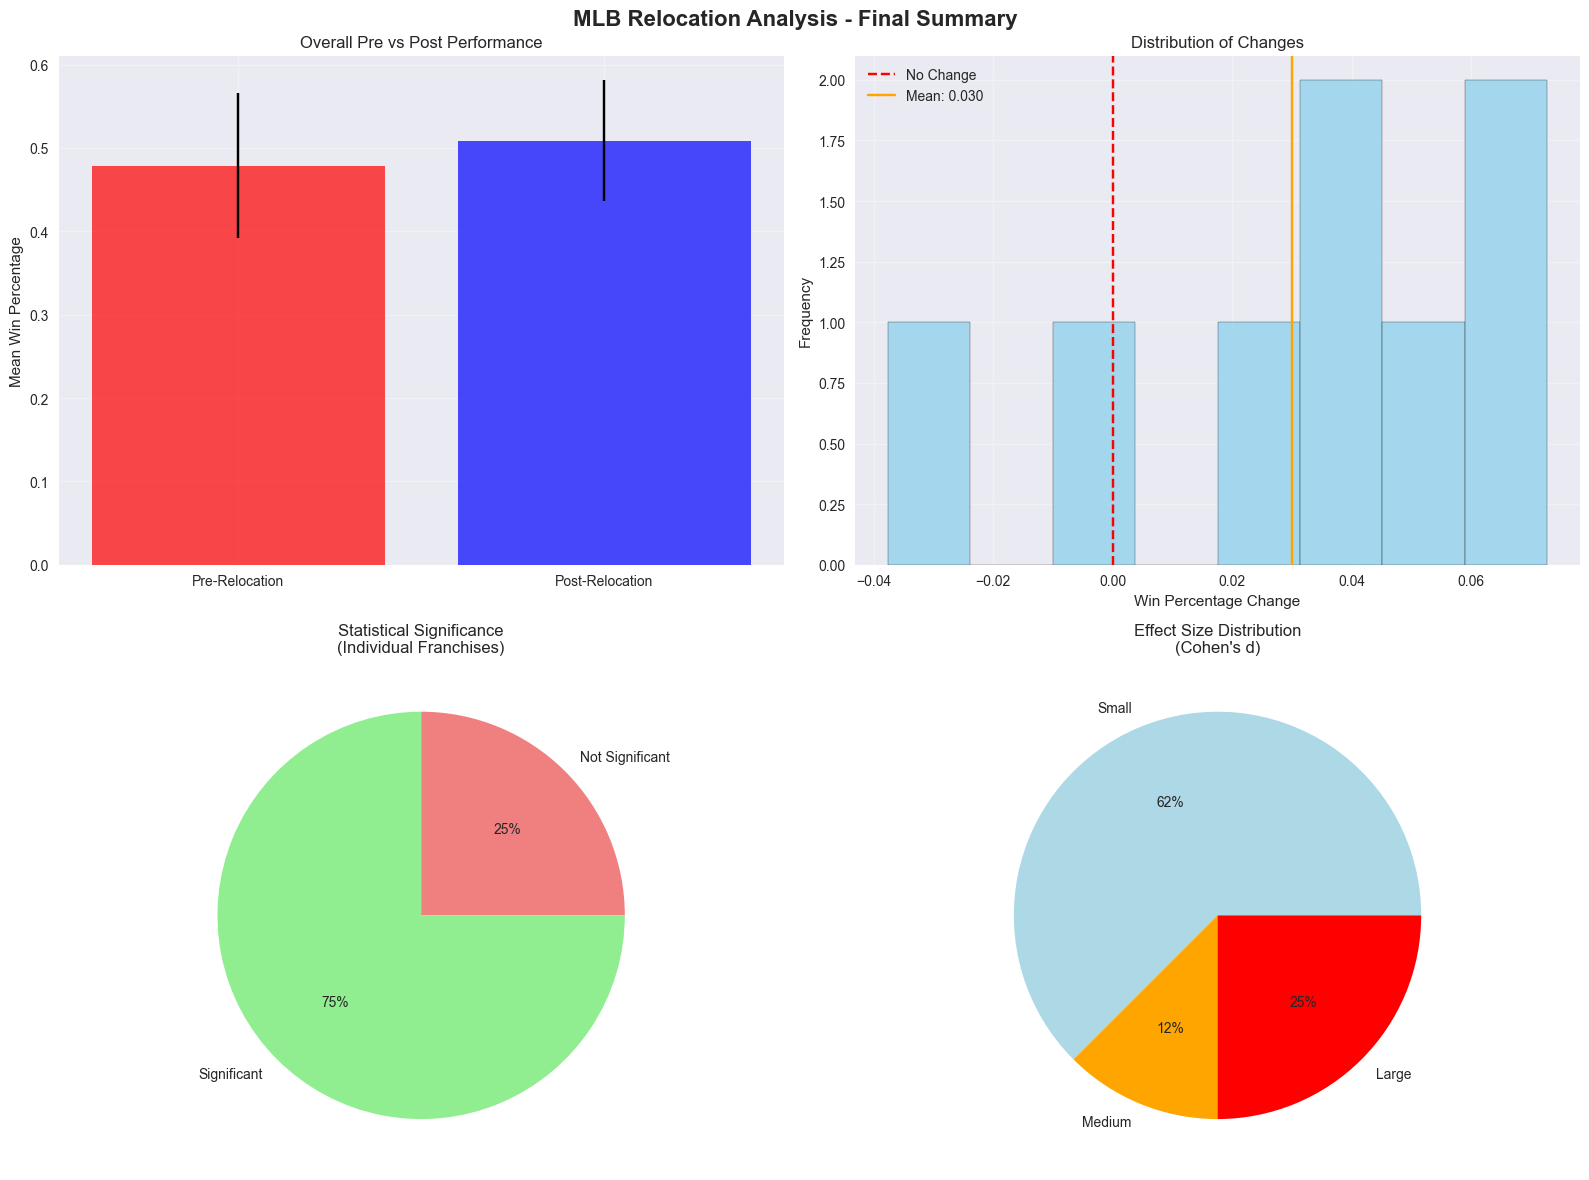

✅ Summary visualization saved to: mlb_relocation_analysis_summary.png

🎉 Analysis complete! All results have been saved.


In [ ]:
# Export detailed results for further analysis or reporting
print("=== EXPORTING RESULTS ===")

# 1. Detailed statistical results
analysis_df_export = analysis_df.copy()
analysis_df_export['effect_size_category'] = analysis_df_export['cohens_d'].apply(
    lambda x: 'Large' if abs(x) >= 0.8 else 'Medium' if abs(x) >= 0.5 else 'Small'
)

analysis_df_export.to_csv('franchise_statistical_analysis.csv', index=False)
print("✅ Detailed statistical analysis saved to: franchise_statistical_analysis.csv")

# 2. Summary report
summary_report = {
    'analysis_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'total_seasons': len(df),
    'relocated_franchises': len(relocation_summary),
    'franchises_analyzed': len(analysis_df),
    'mean_change': changes.mean(),
    'std_change': changes.std(),
    'median_change': np.median(changes),
    'min_change': changes.min(),
    'max_change': changes.max(),
    'positive_changes': (changes > 0).sum(),
    'negative_changes': (changes < 0).sum(),
    't_statistic': t_stat,
    'p_value': p_value,
    'significant': p_value < 0.05,
    'cohens_d': overall_cohens_d,
    'effect_size_interpretation': effect_interpretation,
    'bootstrap_ci_lower': ci_lower,
    'bootstrap_ci_upper': ci_upper,
    'wilcoxon_p': wilcoxon_p,
    'sign_test_p': sign_test_p,
    'power': power
}

summary_df = pd.DataFrame([summary_report])
summary_df.to_csv('analysis_summary_report.csv', index=False)
print("✅ Summary report saved to: analysis_summary_report.csv")

# 3. Create final visualization summary
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('MLB Relocation Analysis - Final Summary', fontsize=16, fontweight='bold')

# Main results
ax1.bar(['Pre-Relocation', 'Post-Relocation'], 
        [analysis_df['pre_mean'].mean(), analysis_df['post_mean'].mean()],
        color=['red', 'blue'], alpha=0.7, capsize=5,
        yerr=[analysis_df['pre_std'].mean(), analysis_df['post_std'].mean()])
ax1.set_ylabel('Mean Win Percentage')
ax1.set_title('Overall Pre vs Post Performance')
ax1.grid(True, alpha=0.3)

# Distribution of changes
ax2.hist(changes, bins=8, alpha=0.7, color='skyblue', edgecolor='black')
ax2.axvline(x=0, color='red', linestyle='--', label='No Change')
ax2.axvline(x=changes.mean(), color='orange', linestyle='-', label=f'Mean: {changes.mean():.3f}')
ax2.set_xlabel('Win Percentage Change')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Changes')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Statistical significance
sig_counts = [len(analysis_df) - analysis_df['significant'].sum(), analysis_df['significant'].sum()]
ax3.pie(sig_counts, labels=['Not Significant', 'Significant'], autopct='%1.0f%%', 
        colors=['lightcoral', 'lightgreen'])
ax3.set_title('Statistical Significance\n(Individual Franchises)')

# Effect sizes
effect_counts = [small_effects, medium_effects, large_effects]
ax4.pie(effect_counts, labels=['Small', 'Medium', 'Large'], autopct='%1.0f%%',
        colors=['lightblue', 'orange', 'red'])
ax4.set_title('Effect Size Distribution\n(Cohen\'s d)')

plt.tight_layout()
plt.savefig('mlb_relocation_analysis_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("Summary visualization saved to: mlb_relocation_analysis_summary.png")
print("\nAnalysis complete! All results have been saved.")

## 16. Additional Exploratory Analysis

In [ ]:
# Additional exploratory questions
print("=== ADDITIONAL EXPLORATORY ANALYSIS ===")

# 1. Do effects persist over time?
print("\n1. PERSISTENCE OF EFFECTS:")
relocated_data = df[df['is_relocated_franchise'] == True]

# Analyze performance in different post-relocation periods
early_post = relocated_data[(relocated_data['post_relocation'] == True) & 
                           (relocated_data['years_since_relocation'] <= 5)]
late_post = relocated_data[(relocated_data['post_relocation'] == True) & 
                          (relocated_data['years_since_relocation'] > 10)]

if len(early_post) > 0 and len(late_post) > 0:
    early_mean = early_post['W_pct'].mean()
    late_mean = late_post['W_pct'].mean()
    persistence_t, persistence_p = ttest_ind(early_post['W_pct'], late_post['W_pct'])
    
    print(f"Early post-relocation (0-5 years): {early_mean:.3f} (n={len(early_post)})")
    print(f"Late post-relocation (10+ years): {late_mean:.3f} (n={len(late_post)})")
    print(f"Difference: {late_mean - early_mean:+.3f}")
    print(f"P-value: {persistence_p:.4f}")
    print(f"Effects persist: {'Yes' if persistence_p >= 0.05 else 'No (significant change over time)'}")

# 2. Multiple relocations
print("\n2. MULTIPLE RELOCATIONS:")
multiple_relocations = ['ATL', 'OAK']  # Franchises with multiple moves
for franchise in multiple_relocations:
    franchise_data = df[df['canonical_franchise'] == franchise]
    if not franchise_data.empty:
        print(f"\n{franchise}:")
        
        # For ATL: Boston → Milwaukee → Atlanta
        if franchise == 'ATL':
            boston_era = franchise_data[franchise_data['yearID'] <= 1952]
            milwaukee_era = franchise_data[(franchise_data['yearID'] >= 1953) & (franchise_data['yearID'] <= 1965)]
            atlanta_era = franchise_data[franchise_data['yearID'] >= 1966]
            
            print(f"  Boston era (1876-1952): {boston_era['W_pct'].mean():.3f} (n={len(boston_era)})")
            print(f"  Milwaukee era (1953-1965): {milwaukee_era['W_pct'].mean():.3f} (n={len(milwaukee_era)})")
            print(f"  Atlanta era (1966-present): {atlanta_era['W_pct'].mean():.3f} (n={len(atlanta_era)})")
            
            if len(boston_era) > 0 and len(milwaukee_era) > 0:
                t1, p1 = ttest_ind(boston_era['W_pct'], milwaukee_era['W_pct'])
                print(f"  Boston → Milwaukee change: {milwaukee_era['W_pct'].mean() - boston_era['W_pct'].mean():+.3f} (p={p1:.4f})")
            
            if len(milwaukee_era) > 0 and len(atlanta_era) > 0:
                t2, p2 = ttest_ind(milwaukee_era['W_pct'], atlanta_era['W_pct'])
                print(f"  Milwaukee → Atlanta change: {atlanta_era['W_pct'].mean() - milwaukee_era['W_pct'].mean():+.3f} (p={p2:.4f})")

# 3. Comparison with expansion teams
print("\n3. COMPARISON WITH EXPANSION TEAMS:")
expansion_teams = ['ARI', 'COL', 'FLA', 'TBD']  # Modern expansion teams
expansion_data = df[df['canonical_franchise'].isin(expansion_teams)]

if len(expansion_data) > 0:
    expansion_mean = expansion_data['W_pct'].mean()
    relocated_mean = relocated_data['W_pct'].mean()
    
    expansion_vs_relocated_t, expansion_vs_relocated_p = ttest_ind(expansion_data['W_pct'], relocated_data['W_pct'])
    
    print(f"Expansion teams mean W%: {expansion_mean:.3f} (n={len(expansion_data)})")
    print(f"Relocated teams mean W%: {relocated_mean:.3f} (n={len(relocated_data)})")
    print(f"Difference: {relocated_mean - expansion_mean:+.3f}")
    print(f"P-value: {expansion_vs_relocated_p:.4f}")
    print(f"Significant difference: {'Yes' if expansion_vs_relocated_p < 0.05 else 'No'}")

print(f"\n✅Analysis notebook complete!✅")

=== ADDITIONAL EXPLORATORY ANALYSIS ===

1. PERSISTENCE OF EFFECTS:
Early post-relocation (0-5 years): 0.498 (n=60)
Late post-relocation (10+ years): 0.524 (n=525)
Difference: +0.026
P-value: 0.0141
Effects persist: No (significant change over time)

2. MULTIPLE RELOCATIONS:

ATL:
  Boston era (1876-1952): 0.486 (n=77)
  Milwaukee era (1953-1965): 0.563 (n=13)
  Atlanta era (1966-present): 0.522 (n=59)
  Boston → Milwaukee change: +0.077 (p=0.0144)
  Milwaukee → Atlanta change: -0.042 (p=0.0727)

OAK:

3. COMPARISON WITH EXPANSION TEAMS:
Expansion teams mean W%: 0.475 (n=118)
Relocated teams mean W%: 0.508 (n=1104)
Difference: +0.033
P-value: 0.0001
Significant difference: Yes

✨ Analysis notebook complete! ✨
